In [ ]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
demo = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_01_DEMO.csv") #고객 데모 정보
pdde = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_02_PDDE.csv") #상품 구매 정보(유통사 상품 구매 내역)
pd_clac = pd.read_csv("/content/drive/MyDrive/롯데 공모전/dataset/LPOINT_BIG_COMP_04_PD_CLAC.csv") #상품 분류 정보(유통사 상품 카테고리 마스터)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df = pd.merge(pdde, pd_clac,how='outer',on='pd_c')
df = pd.merge(df, demo, how='left', on='cust')
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
1,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
3,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17
4,M506355556,A01000107137,1,A01,A010032,PD0290,20210101,15,199000.0,1,남성티셔츠,남성의류,남성의류상의,여성,40대,Z17


- 이상치 제거

In [ ]:
df=df[df['cust']!='M057015266']
df=df[df['cust']!='M919374790']
print(df.shape)

(4359246, 16)


- 날짜 변수 추가

In [ ]:
from datetime import datetime

a = df['de_dt'].astype('str')
df['de_dt']  = pd.to_datetime(a)
df['month'] = df['de_dt'].dt.month
df['day'] = df['de_dt'].dt.day

df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm,ma_fem_dv,ages,zon_hlv,days,month,day
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,Friday,1,1
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,Friday,1,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,Friday,1,1
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,남성티셔츠,남성의류,남성의류상의,여성,50대,Z17,Friday,1,1
4,M506355556,A01000107137,1,A01,A010032,PD0290,2021-01-01,15,199000.0,1,남성티셔츠,남성의류,남성의류상의,여성,40대,Z17,Friday,1,1


- 계절변수

In [ ]:
#계절변수
def wea_fun(x):
  y=''
  if x==3 or x==4 or x==5: y='spr'
  elif x==6 or x==7 or x==8: y='smn'
  elif x==9 or x==10 or x==11: y='atm'
  else: y='win'
  return y

#함수 적용
df["weat"] = df["month"].apply(lambda x: wea_fun(x))

- 시간변수

In [ ]:
def time_fun(x):
  y=''
  if (x>=11 and x <22): y=1 #주로 상품의 구매가 이뤄지는 시간대
  else: y = 0 #비주류 시간대
  return y

#함수 적용
df["de_hr_1"] = df["de_hr"].apply(lambda x: time_fun(x))

- 고객의 총 주문한 상품 수

In [ ]:
order = df.groupby('cust').sum()['buy_ct'].rename_axis('cust').reset_index(name='total_items') #고객의 총 주문한 상품 수
df = pd.merge(df, order, how='outer',on='cust')

- 공휴일 변수

In [ ]:
#주말이 아닌 공휴일 변수
holi=[]
holiday=['0101','0211','0212','0301','0505','0519','0816','0920','0921','0922','1004','1011']
for h in holiday:
  holi.append('2021'+h)

c = pd.to_datetime(holi)
df['holi']=df.de_dt.apply(lambda x: 1 if x in c else 0)

- 주말, 평일 변수

In [ ]:
datedict={0:'mon',1:'tue',2:'wed',3:'thu',4:'fri',5:'sat',6:'sun'}
df["weekday"] = df["de_dt"].apply(lambda x: datedict[x.weekday()])
df['weekday']=df.weekday.apply(lambda x: 1 if x=='sat' or x=='sun' else 0)

- 재구매 여부 및 재구매 간격

In [ ]:
rebuy_df = df.groupby(['cust', 'clac_mcls_nm','de_dt']).sum()['buy_ct'].reset_index(name='buy_cnt') 
rebuy_df = rebuy_df.sort_values(['cust','clac_mcls_nm','de_dt'])

# 해당 카테고리의 상품 구매 간격
rebuy_df['rebuy_diff'] = rebuy_df['de_dt'].diff()
rebuy_df.loc[rebuy_df['cust'] != rebuy_df['cust'].shift(),'rebuy_diff'] = None 
rebuy_df.loc[rebuy_df['clac_mcls_nm'] != rebuy_df['clac_mcls_nm'].shift(),'rebuy_diff'] = None
rebuy_df['rebuy_diff'] = rebuy_df['rebuy_diff'].dt.days4

# 구매가 없는 경우 365일로 간주
rebuy_df['rebuy_diff'] = rebuy_df['rebuy_diff'].fillna(365)

# 31일 내에 재구매가 이뤄진 경우 1, 안이뤄진 경우 0
rebuy_df['rebuy'] = 0
rebuy_df.loc[rebuy_df['rebuy_diff'] <= 31,'rebuy'] = 1

In [ ]:
# 재구매 간격의 평균
rebuy_df2= rebuy_df.groupby(by=['cust','clac_mcls_nm']).mean()['rebuy_diff']

In [ ]:
del rebuy_df['rebuy_diff']
del rebuy_df['buy_cnt']

In [ ]:
rebuy_df = pd.merge(rebuy_df, rebuy_df2, how='outer',on=['cust','clac_mcls_nm'])
df = pd.merge(df, rebuy_df, how='outer',on=['cust','clac_mcls_nm','de_dt'])
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,days,month,day,weat,de_hr_1,total_items,holi,weekday,rebuy,rebuy_diff
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,Friday,1,1,win,2,580,1,0,0,238.0
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Friday,1,1,win,2,580,1,0,0,238.0
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Friday,1,1,win,2,580,1,0,0,238.0
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,Friday,1,1,win,2,580,1,0,0,238.0
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,Friday,1,1,win,1,580,1,0,0,238.0


- 총 재구매 횟수 및 재구매 비율

In [ ]:
rebuy_df = df.groupby(['cust', 'clac_mcls_nm']).sum()['buy_ct'].reset_index(name='rebuy_cnt') # 각 카테고리의 상품 구매 횟수
rebuy_df['rebuy_cnt'] -= 1 # 처음 구매는 재구매가 아니므로 제외
rebuy_df = rebuy_df.groupby('cust').sum()['rebuy_cnt'].reset_index(name='rebuy_cnt') # 해당 cust의 총 재구매 횟수의 합

df = pd.merge(df, rebuy_df, how='outer',on='cust')
df.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,month,day,weat,de_hr_1,total_items,holi,weekday,rebuy,rebuy_diff,rebuy_cnt
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,...,1,1,win,2,580,1,0,0,238.0,496
1,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,1,1,win,2,580,1,0,0,238.0,496
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,1,1,win,2,580,1,0,0,238.0,496
3,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,...,1,1,win,2,580,1,0,0,238.0,496
4,M430112881,A01000013098,1,A01,A010039,PD0292,2021-01-01,11,19900.0,1,...,1,1,win,1,580,1,0,0,238.0,496


In [ ]:
df['rebuy_ration'] = df['rebuy_cnt']/df['total_items']*100 # 재구매 횟수 / 전체 구매 횟수 * 100

- 상품 구매 간격(어떤 상품이든 관계없이, 소비자의 상품 구매 간격)

In [ ]:
df = df.sort_values(['cust','de_dt'])
df['dt_diff'] = df['de_dt'].diff()
df.loc[df['cust'] != df['cust'].shift(),'dt_diff'] = None
df['dt_diff'] = df['dt_diff'].dt.days
df['dt_diff'] = df['dt_diff'].fillna(365)

- 나이

In [ ]:
df['ages']=df.ages.apply(lambda x: int(x[:-1])+5)

- 계절 변수

In [ ]:
weat_list = df['weat'].value_counts().index[::-1]
weat_dict = dict(zip(weat_list, range(0,4)))
df = df.replace({'weat': weat_dict})

- 성별 변수

In [ ]:
ma_fem_list = df['ma_fem_dv'].value_counts().index[::-1]
ma_fem_dict = dict(zip(ma_fem_list, range(0,2)))
df = df.replace({'ma_fem_dv': ma_fem_dict})

- 구매 지역: 수도권 및 비수도권

In [ ]:
df['zon_hlv']=df['zon_hlv'].apply(lambda x: 1 if x=='Z17' or x=='Z10' else 0)

- 최종 데이터 

In [ ]:
df = df.drop([ 'chnl_dv', 'cop_c', 'br_c', 'pd_c', 'de_hr', 'pd_nm', 'clac_hlv_nm','month', 'day', 'rct_no','de_dt'], axis=1)
df.head()

,cust,buy_am,buy_ct,clac_mcls_nm,ma_fem_dv,ages,zon_hlv,days,weat,de_hr_1,total_items,holi,weekday,rebuy,rebuy_diff,rebuy_cnt,rebuy_ration,dt_diff
3573838,M000034966,100.0,1,스포츠잡화,1,45,Z07,Saturday,2,1,63,0,1,0,365.0,34,53.968254,365.0
3573839,M000034966,59000.0,1,남성스포츠화,1,45,Z07,Saturday,2,1,63,0,1,0,365.0,34,53.968254,0.0
3573840,M000034966,19000.0,1,남성스포츠화,1,45,Z07,Saturday,2,1,63,0,1,0,365.0,34,53.968254,0.0
3573841,M000034966,62100.0,1,여성스포츠화,1,45,Z07,Saturday,2,1,63,0,1,0,365.0,34,53.968254,0.0
3573847,M000034966,1200.0,1,과채음료,1,45,Z07,Saturday,2,1,63,0,1,0,365.0,34,53.968254,0.0


- 상관관계 파악

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


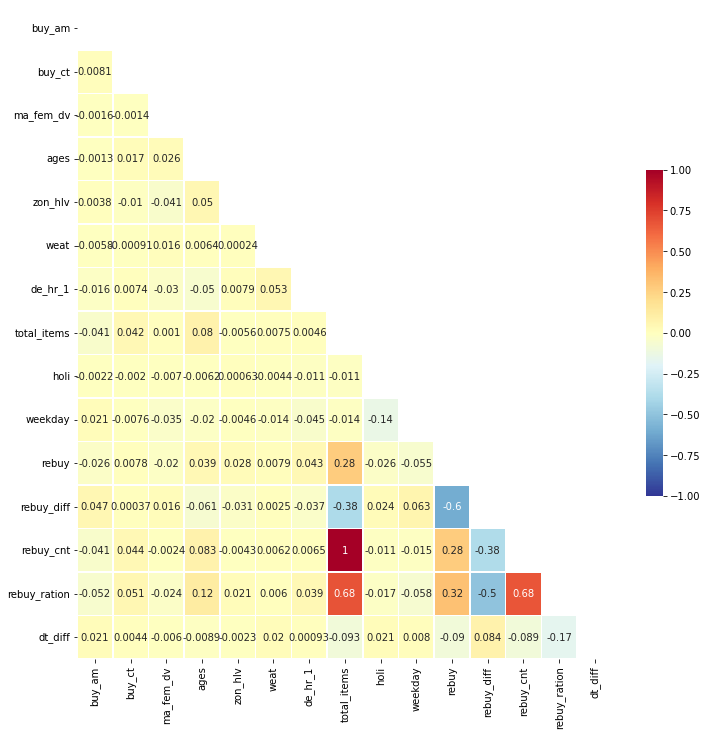

In [74]:
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(12,12) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df2.corr(), 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

In [ ]:
df.corr().loc["rebuy"].abs().sort_values(ascending=False)

rebuy           1.000000
rebuy_diff      0.598472
rebuy_ration    0.322548
rebuy_cnt       0.277469
total_items     0.275748
dt_diff         0.089827
weekday         0.054675
de_hr_1         0.042922
ages            0.039359
zon_hlv         0.028393
holi            0.025971
buy_am          0.025635
ma_fem_dv       0.019556
weat            0.007940
buy_ct          0.007766
Name: rebuy, dtype: float64

In [ ]:
df2.to_csv('lotto_df.csv') #csv파일로 생성